## Data Preparation

In [18]:
import os
# Root = "/kaggle/input/d/hamadismail/ravdesslite/ravdesslite/"
Root = "/kaggle/input/ravdess/"
os.chdir(Root)

# Importing Libraries

In [19]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

##  <center> 1. Ravdess Dataframe <center>


In [20]:
ravdess_directory_list = os.listdir(Root)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Root + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Root + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess/Actor_02/03-01-08-01-01-...
1,neutral,/kaggle/input/ravdess/Actor_02/03-01-01-01-01-...
2,disgust,/kaggle/input/ravdess/Actor_02/03-01-07-02-01-...
3,disgust,/kaggle/input/ravdess/Actor_02/03-01-07-01-01-...
4,neutral,/kaggle/input/ravdess/Actor_02/03-01-01-01-02-...


In [21]:
# creating Dataframe using ravdees dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("/kaggle/working/data_path.csv",index=False)
# data_path.head()

In [22]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sr=22050, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [24]:
def extract_features(data):

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_chroma=64)
    # If the resulting Chroma_stft matrix has fewer frames than n_frames, you can pad it.
    if chroma_stft.shape[1] < 108:
        pad_width = 108 - chroma_stft.shape[1]
        chroma_stft = np.pad(chroma_stft, ((0, 0), (0, pad_width)), mode='constant')

    # If the resulting Chroma_stft matrix has more frames than n_frames, you can truncate it.
    if chroma_stft.shape[1] > 108:
        chroma_stft = chroma_stft[:, :108]
    
    
    # MFCC
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=64)
    # If the resulting MFCC matrix has fewer frames than n_frames, you can pad it.
    if mfccs.shape[1] < 108:
        pad_width = 108 - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')

    # If the resulting MFCC matrix has more frames than n_frames, you can truncate it.
    if mfccs.shape[1] > 108:
        mfccs = mfccs[:, :108]
          
    # MelSpectogram
    mel = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=64)
    # If the resulting MelSpectogram matrix has fewer frames than n_frames, you can pad it.
    if mel.shape[1] < 108:
        pad_width = 108 - mel.shape[1]
        mel = np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')

    # If the resulting MelSpectogram matrix has more frames than n_frames, you can truncate it.
    if mel.shape[1] > 108:
        mel = mel[:, :108]
        
    result = np.stack((chroma_stft, mfccs,mel)) # stacking horizontally 
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data) # 13
    result = np.array(res1) # (13, )

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data) # (13, )
    result = np.vstack((result, res2)) # stacking vertically (2, 13)
    
    result = result.reshape(2, 64, 108, 3)
    
    return result

In [70]:
X, Y = [], []

for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)

    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [71]:
print(feature.shape)
print(ele.shape)

(2, 64, 108, 3)
(64, 108, 3)


In [72]:
X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape, len(X), len(Y))

(2880, 64, 108, 3) (2880,) 2880 2880


In [73]:
num_samples = len(X)
num_frequency_bins = X[0].shape[0]
num_time_steps = X[0].shape[1]
num_fea_type = X[0].shape[2]

print("Number of samples:", num_samples)
print("Number of frequency bins:", num_frequency_bins)
print("Number of time steps:", num_time_steps)
print("Number of feature_method:", num_fea_type)

Number of samples: 2880
Number of frequency bins: 64
Number of time steps: 108
Number of feature_method: 3


In [74]:
# Flatten the 3D feature array into 2D
X_flattened = X.reshape(X.shape[0], -1)

Features = pd.DataFrame(X_flattened)
Features['labels'] = Y
Features.to_csv('/kaggle/working/features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,20727,20728,20729,20730,20731,20732,20733,20734,20735,labels
0,0.640621,0.584586,0.294758,0.930414,0.839562,0.716970,0.696003,0.538788,0.790537,0.664406,...,3.530530e-21,2.619690e-21,3.700222e-21,2.829482e-21,3.416731e-21,4.632053e-21,5.757013e-21,1.252495e-14,1.558426e-12,surprise
1,0.925821,0.775044,0.649532,0.820208,0.814020,0.875250,0.919444,0.877685,0.852774,0.809967,...,2.416428e-04,2.095381e-04,2.175623e-04,2.100746e-04,2.137787e-04,2.700951e-04,2.278186e-04,2.213009e-04,1.711523e-04,surprise
2,0.511710,0.670306,0.702366,0.558945,0.654863,0.731830,0.680316,0.814203,0.709732,0.708049,...,4.309546e-21,4.275326e-21,4.392627e-21,4.250608e-21,5.017241e-21,1.093072e-20,1.544392e-20,1.061716e-14,1.317884e-12,neutral
3,0.987344,0.846813,0.760471,0.878396,0.938105,0.841244,0.800621,0.738786,0.856507,0.792908,...,1.458403e-04,1.171256e-04,1.057644e-04,1.216389e-04,1.582111e-04,1.526281e-04,1.431587e-04,1.391766e-04,1.228387e-04,neutral
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.815221,0.730163,0.502553,...,2.897971e-16,3.014416e-16,2.750594e-16,2.439737e-16,2.113277e-16,2.318701e-16,1.374101e-16,2.476174e-10,3.118962e-08,disgust


## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [75]:
# X = Features.iloc[: ,:-1].values
X = np.array(Features.iloc[:, :-1].values).reshape(num_samples, num_frequency_bins, num_time_steps, num_fea_type)
Y = Features['labels'].values

In [76]:
from sklearn.preprocessing import OneHotEncoder
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [77]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2304, 64, 108, 3), (2304, 8), (576, 64, 108, 3), (576, 8))

In [78]:
from sklearn.preprocessing import StandardScaler

# Reshape the data to 2D
x_train_2d = x_train.reshape(x_train.shape[0], -1)
x_test_2d = x_test.reshape(x_test.shape[0], -1)

# Apply StandardScaler to the 2D data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_2d)
x_test_scaled = scaler.transform(x_test_2d)

# Reshape the scaled data back to 3D
x_train = x_train_scaled.reshape(x_train.shape[0], num_frequency_bins, num_time_steps, num_fea_type)
x_test = x_test_scaled.reshape(x_test.shape[0], num_frequency_bins, num_time_steps, num_fea_type)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((2304, 64, 108, 3), (2304, 8), (576, 64, 108, 3), (576, 8))

## Modelling

In [85]:
import keras
from keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
import numpy as np

# Define the model
model = Sequential()

# First Conv3D layer
model.add(Conv3D(64, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', input_shape=(num_frequency_bins, num_time_steps, num_fea_type, 1)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

# Second Conv3D layer
model.add(Conv3D(128, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1)))

# Second Conv3D layer
model.add(Conv3D(128, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1)))

# Third Conv3D layer
model.add(Conv3D(256, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1)))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
# model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_61 (Conv3D)          (None, 64, 108, 3, 64)    1792      
                                                                 
 batch_normalization_61 (Bat  (None, 64, 108, 3, 64)   256       
 chNormalization)                                                
                                                                 
 max_pooling3d_61 (MaxPoolin  (None, 32, 54, 1, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_62 (Conv3D)          (None, 32, 54, 1, 128)    221312    
                                                                 
 batch_normalization_62 (Bat  (None, 32, 54, 1, 128)   512       
 chNormalization)                                                
                                                     

In [86]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
36/36 [==============================] - 10s 186ms/step - loss: 3.2779 - accuracy: 0.2318 - val_loss: 2.3123 - val_accuracy: 0.1753 - lr: 0.0010
Epoch 2/100
36/36 [==============================] - 6s 159ms/step - loss: 2.0187 - accuracy: 0.2582 - val_loss: 7.4044 - val_accuracy: 0.1285 - lr: 0.0010
Epoch 3/100
36/36 [==============================] - 6s 160ms/step - loss: 1.8865 - accuracy: 0.2665 - val_loss: 9.7498 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 4/100
36/36 [==============================] - 6s 161ms/step - loss: 1.8352 - accuracy: 0.2769 - val_loss: 8.9337 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 5/100
36/36 [==============================] - 6s 162ms/step - loss: 1.8137 - accuracy: 0.2869 - val_loss: 8.8649 - val_accuracy: 0.1215 - lr: 0.0010
Epoch 6/100
36/36 [==============================] - 6s 162ms/step - loss: 1.7494 - accuracy: 0.3016 - val_loss: 6.3720 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 7/100
36/36 [==============================] - 6s 162ms/s

18/18 [==============================] - 1s 29ms/step - loss: 0.5020 - accuracy: 0.9010
Accuracy of our model on test data :  90.10416865348816 %


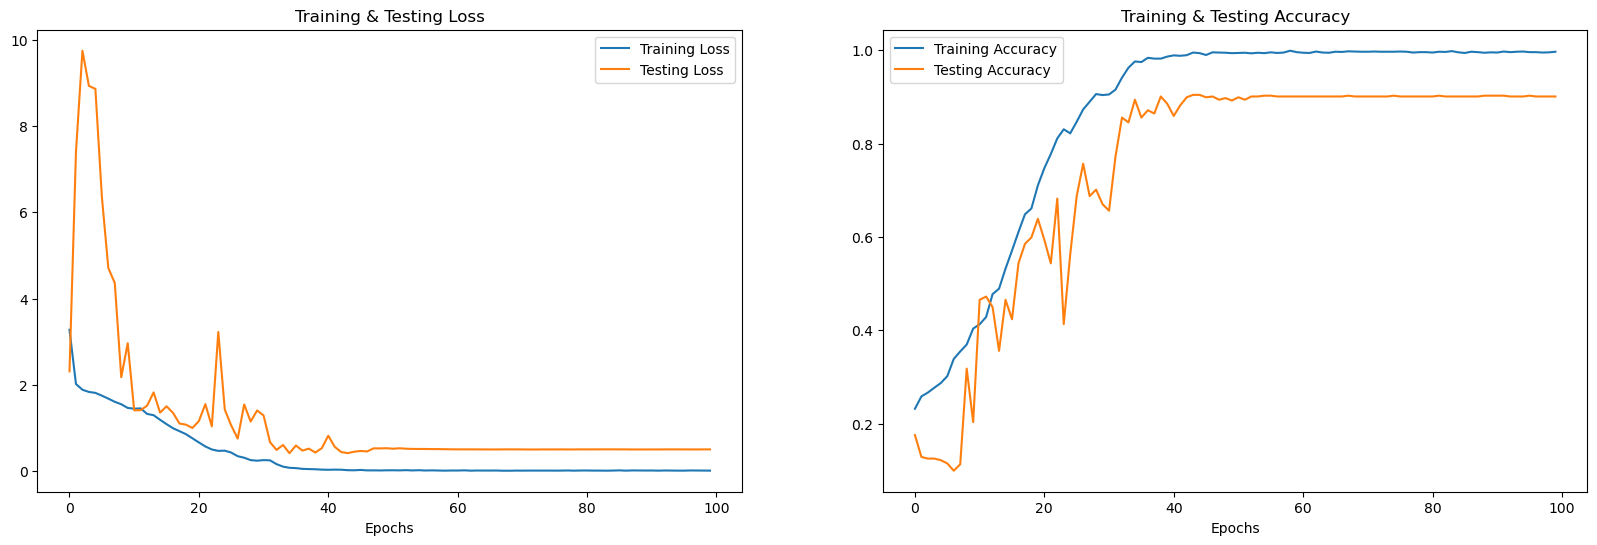

In [87]:
import matplotlib.pyplot as plt

print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [88]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

18/18 [==============================] - 1s 27ms/step


In [89]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,angry,angry
1,sad,sad
2,calm,calm
3,fear,fear
4,calm,calm
5,disgust,disgust
6,disgust,disgust
7,angry,angry
8,neutral,neutral
9,sad,sad


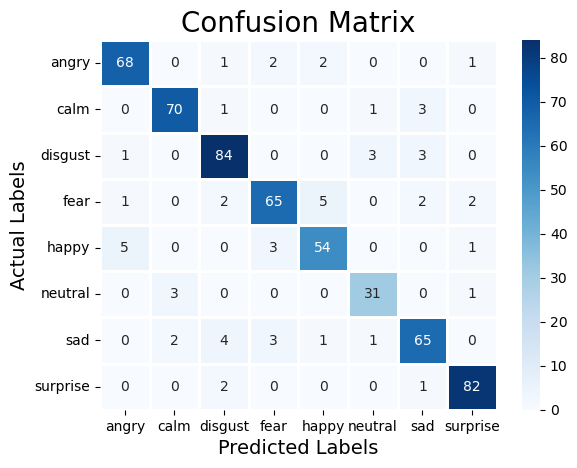

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [91]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

       angry       0.91      0.92      0.91        74
        calm       0.93      0.93      0.93        75
     disgust       0.89      0.92      0.91        91
        fear       0.89      0.84      0.87        77
       happy       0.87      0.86      0.86        63
     neutral       0.86      0.89      0.87        35
         sad       0.88      0.86      0.87        76
    surprise       0.94      0.96      0.95        85

    accuracy                           0.90       576
   macro avg       0.90      0.90      0.90       576
weighted avg       0.90      0.90      0.90       576

